# HMC

In [1]:
import jax 
import jax.numpy as jnp
from jax import jit, vmap
from jax import random
from src.models.vsh_model import*
from src.models.configuration import*
from src.data.data_utils import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist

/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:93: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:144: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:203: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = load_filtered_qso_df() # load filetered data
angles, obs, error = config_data(df)

In [3]:
def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)//2
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta_t = numpyro.sample("theta_t", dist.Uniform(-0.5, 0.5).expand([total_params]))
    theta_s = numpyro.sample("theta_s", dist.Uniform(-0.1, 0.1).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = least_square_hmc(angles, obs, error, theta_t, theta_s, lmax=lmax, grid=False)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)


In [4]:
kernel = NUTS(model_for_HMC, target_accept_prob=0.8)
rng_key = jax.random.key(0)
mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=4, progress_bar=True)
mcmc.run(rng_key, angles=angles, obs=obs, error=error, lmax=3)

posterior_sample = mcmc.get_samples()

/tmp/ipykernel_3381/2362444259.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=4, progress_bar=True)
warmup:   2%|▏         | 41/2100 [01:42<1:25:52,  2.50s/it, 127 steps of size 1.45e-03. acc. prob=0.71]


KeyboardInterrupt: 

In [5]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 theta_s[0]     -0.01      0.00     -0.01     -0.01     -0.01   9381.55      1.00
 theta_s[1]      0.00      0.00      0.00     -0.00      0.00   5848.14      1.00
 theta_s[2]     -0.02      0.00     -0.02     -0.02     -0.01   9816.93      1.00
 theta_s[3]     -0.00      0.00     -0.00     -0.01     -0.00   3845.41      1.00
 theta_s[4]      0.01      0.00      0.01      0.01      0.01   8567.87      1.00
 theta_s[5]      0.01      0.00      0.01      0.01      0.01   8895.31      1.00
 theta_s[6]     -0.01      0.00     -0.01     -0.01     -0.01   9340.57      1.00
 theta_s[7]      0.01      0.00      0.01      0.00      0.01   7623.10      1.00
 theta_s[8]      0.00      0.00      0.00      0.00      0.00   6062.46      1.00
 theta_s[9]      0.00      0.00      0.00     -0.00      0.00   4559.99      1.00
theta_s[10]      0.00      0.00      0.00      0.00      0.01   8384.84      1.00
theta_s[11]    

In [6]:
s_lm = jnp.mean(posterior_sample['theta_s'], axis=0)
t_lm = jnp.mean(posterior_sample['theta_t'], axis=0)
std_s = jnp.std(posterior_sample['theta_s'], axis=0)
std_t = jnp.std(posterior_sample['theta_t'], axis=0)

In [7]:
spheroidal_vector_summary(s_lm, std_s**2, index = np.array([0,1,2]))

Equatorial components:
G_vec = [-0.45088786 -8.202835   -2.5381043 ] +/- [0.8384631  0.6853078  0.33379656](μas/yr)
Magnitude = 8.598358154296875 +/- 1.371079444885254 (μas/yr)
RA = 266.8537902832031 +/- 11.962297439575195 (deg)
Dec = -17.168615341186523 +/- 0.1920270472764969 (deg)

Galactic components:
G_vec = [8.41742678 1.53015725 0.85867355] +/- [0.62168318 0.57161122 0.75555141](μas/yr)
l = 10.302975325315133 +/- 3.83928927986359 (deg)
d = 5.731386556920483 +/- 0.40928258879805446 (deg)


In [8]:
toroidal_vector_summary(t_lm, std_t, index = np.array([0,1,2]))

R_vec = [ 5.5001535 -2.4638968 -0.7120509] +/- [17.297695 16.898705 10.669681](μas/yr)
Magnitude = 6.06873083114624 +/- 35.2105598449707 (μas/yr)
RA = 335.8691101074219 +/- 330.11083984375 (deg)
Dec = -6.738097667694092 +/- 35.832176208496094 (deg)


Try to extract covariance of VSH coefficients after determining posterior distribution

In [14]:
def cov_matrix_hmc(posterior_sample, indices=None):
    theta_samples = np.array(posterior_sample)
    cov_matrix = np.cov(theta_samples, rowvar=False)
    
    if indices is not None:
        cov_matrix = cov_matrix[np.ix_(indices, indices)]

    return cov_matrix


In [15]:
cov_slm = cov_matrix_hmc(posterior_sample["theta_s"], indices=[0,1,2])

In [16]:
correlation_slm = rho_matrix(cov_slm)
print(correlation_slm.shape)
print("Correlation matrix of spheroidal coefficients of VSH")
print(correlation_slm)
print('')
print("Example:")
print(f"rho(s11r,s11i) = {correlation_slm[0][1]}")

(3, 3)
Correlation matrix of spheroidal coefficients of VSH
[[ 1.         -0.02017899 -0.00758782]
 [-0.02017899  1.         -0.00990544]
 [-0.00758782 -0.00990544  1.        ]]

Example:
rho(s11r,s11i) = -0.020178985647500453


In [17]:
summary_equatorial, v_vec, Sigma_v = vsh_vector_summary(s_lm, cov_slm)

In [18]:
summary_equatorial

{'|g| (μas/yr)': np.float32(4.6404495),
 'g (μas/yr)': array([-1.4547749, -3.8274574, -2.1835685], dtype=float32),
 '|sigma_g| (μas/yr)': np.float64(0.5649745527185548),
 'sigma_g (μas/yr)': array([0.39173117, 0.66508133, 0.05693069]),
 'Corr_gx_gy': np.float64(0.020178985647500453),
 'Corr_gx_gz': np.float64(0.007587822208358225),
 'Corr_gy_gz': np.float64(-0.009905442567999235)}

In [19]:
alpha_delta_result = alpha_delta_summary(v_vec, Sigma_v)

In [20]:
alpha_delta_result

{'RA (deg)': np.float32(249.18875),
 'Sigma_RA (deg)': np.float64(3.9594852777931036),
 'Dec (deg)': np.float32(-28.070072),
 'Sigma_Dec (deg)': np.float64(3.9594852777931036),
 'Corr_RA_dec': np.float64(0.9721501459177418)}

### Using the same posterior

In [1]:
import jax 
import jax.numpy as jnp
from jax import jit, vmap
from jax import random
from src.models.vsh_model import*
from src.models.configuration import*
from src.data.data_utils import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import transforms

/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_filtered_qso_df() # load filetered data
angles, obs, error = config_data(df)

### Using Uniform Distribution as Prior

In [3]:
def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-.01, .01).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = least_square(angles, obs, error, theta, lmax=lmax, grid=False)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

HMC

In [4]:
kernel = NUTS(model_for_HMC, target_accept_prob=0.8)
rng_key = jax.random.key(2)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, num_chains=4, progress_bar=True)
mcmc.run(rng_key, angles=angles, obs=obs, error=error, lmax=3)

posterior_sample = mcmc.get_samples()

/tmp/ipykernel_72639/3004625032.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, num_chains=4, progress_bar=True)
sample: 100%|██████████| 6000/6000 [09:21<00:00, 10.69it/s, 15 steps of size 3.37e-01. acc. prob=0.87]


In [5]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.00      0.00      0.00     -0.00      0.00  16772.53      1.00
  theta[1]     -0.01      0.00     -0.01     -0.01     -0.01  12954.74      1.00
  theta[2]     -0.01      0.00     -0.01     -0.01     -0.01  19979.48      1.00
  theta[3]      0.01      0.00      0.01      0.00      0.01  13989.69      1.00
  theta[4]      0.00      0.00      0.00     -0.00      0.00  17737.43      1.00
  theta[5]     -0.01      0.00     -0.01     -0.01     -0.01  22802.07      1.00
  theta[6]      0.01      0.00      0.01      0.00      0.01  14197.97      1.00
  theta[7]     -0.00      0.00     -0.00     -0.01     -0.00  20349.52      1.00
  theta[8]      0.00      0.00      0.00      0.00      0.00  20885.68      1.00
  theta[9]      0.00      0.00      0.00     -0.00      0.00  19044.54      1.00
 theta[10]      0.01      0.00      0.01      0.01      0.01  14446.04      1.00
 theta[11]      0.01      0

In [6]:
coeff_est = jnp.mean(posterior_sample['theta'], axis = 0)
std_coeff = jnp.std(posterior_sample['theta'], axis = 0)
spheroidal_vector_summary(coeff_est, std_coeff**2)

Equatorial components:
G_vec = [-0.0735372 -4.778656  -2.6210475] +/- [0.7500972  0.10510066 0.31263444](μas/yr)
Magnitude = 5.450766086578369 +/- 0.47468411922454834 (μas/yr)
RA = 269.11834716796875 +/- 18.40250015258789 (deg)
Dec = -28.74148941040039 +/- 0.12587442994117737 (deg)

Galactic components:
G_vec = [ 5.44604547  0.13147654 -0.18481048] +/- [0.18166445 0.44055621 0.66658871](μas/yr)
l = 1.3829462149007756 +/- 4.632454657770069 (deg)
d = -1.9430095158481924 +/- 0.07513164544142618 (deg)


### Using Beta Distribution as Prior

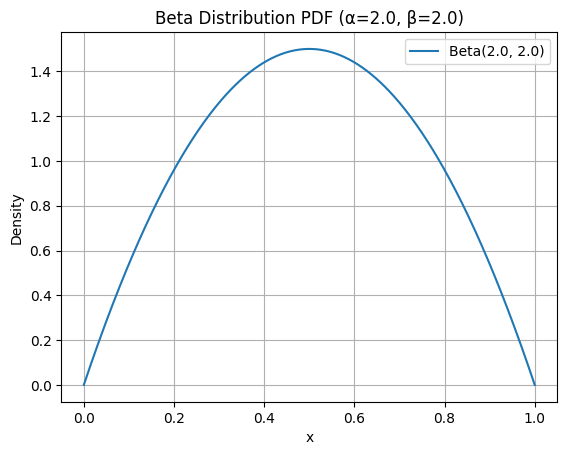

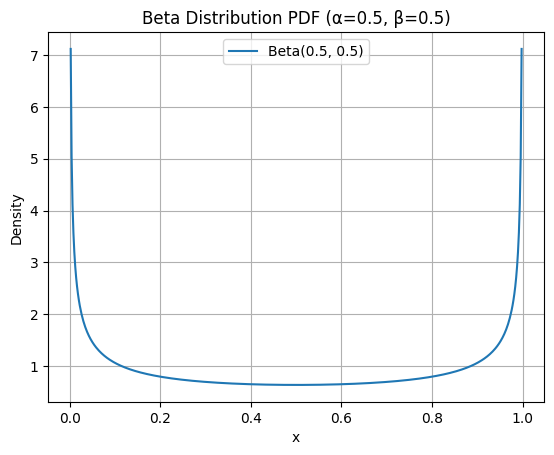

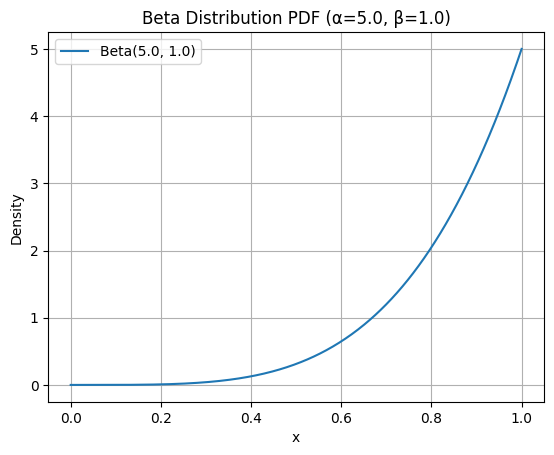

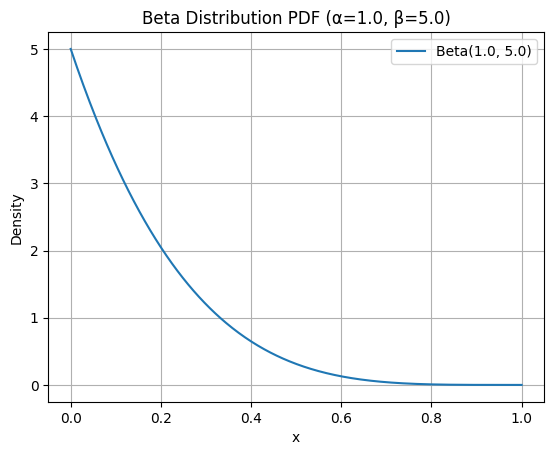

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_beta_pdf(alpha, beta_param):
    x = np.linspace(0, 1, 500)
    y = beta.pdf(x, alpha, beta_param)

    plt.plot(x, y, label=f'Beta({alpha}, {beta_param})')
    plt.title(f'Beta Distribution PDF (α={alpha}, β={beta_param})')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
plot_beta_pdf(2.0, 2.0)     # symmetric bell-shaped
plot_beta_pdf(0.5, 0.5)     # U-shaped (peaked at 0 and 1)
plot_beta_pdf(5.0, 1.0)     # skewed toward 1
plot_beta_pdf(1.0, 5.0)     # skewed toward 0


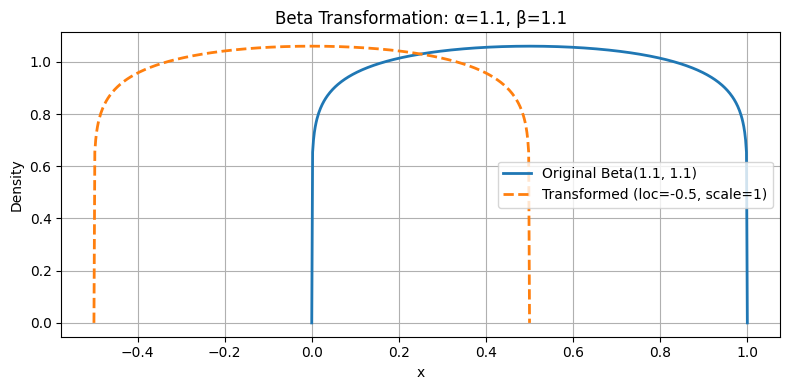

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_beta_transformation(alpha, beta_param, loc, scale):
    # Original Beta support and PDF
    x_base = np.linspace(0, 1, 500)
    y_base = beta.pdf(x_base, alpha, beta_param)
    
    # Transformed x and corresponding PDF
    x_transformed = loc + scale * x_base
    y_transformed = y_base / scale  # Adjust for scaling in PDF

    # Plot both
    plt.figure(figsize=(8, 4))
    plt.plot(x_base, y_base, label=f'Original Beta({alpha}, {beta_param})', lw=2)
    plt.plot(x_transformed, y_transformed, label=f'Transformed (loc={loc}, scale={scale})', lw=2, linestyle='--')
    plt.title(f'Beta Transformation: α={alpha}, β={beta_param}')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: try changing these!
plot_beta_transformation(alpha=1.1, beta_param=1.1, loc=-0.5, scale=1)


In [43]:
def model_for_HMC_beta(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Transform Beta distribution so that is shifted to -0.1, 0.1
    base_beta = dist.Beta(1.1, 1.1).expand([total_params]) 
    transform = transforms.AffineTransform(loc = -0.5, scale = 1.0)
    dist_transformed = dist.TransformedDistribution(base_beta, transform)

    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist_transformed)

    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = least_square(angles, obs, error, theta, lmax=lmax, grid=False)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

In [44]:
kernel = NUTS(model_for_HMC_beta, target_accept_prob=0.75)
rng_key = jax.random.key(0)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, num_chains=4, progress_bar=True)
mcmc.run(rng_key, angles=angles, obs=obs, error=error, lmax=3)

posterior_sample = mcmc.get_samples()
mcmc.print_summary()

/tmp/ipykernel_66556/2102176182.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, num_chains=4, progress_bar=True)


RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [10]:
key = random.PRNGKey(0)
total_params = count_vsh_coeffs(3)
base_beta = dist.Beta(2.0, 2.0).expand([total_params])
transform = transforms.AffineTransform(loc=-0.01, scale=0.02)
dist_theta = dist.TransformedDistribution(base_beta, transform)

theta_sample = dist_theta.sample(key)
print("theta sample:", theta_sample)
print("log prob:", dist_theta.log_prob(theta_sample))
print("chi2:", least_square(angles, obs, error, theta_sample, lmax=3, grid=False))

theta sample: [-0.00050796 -0.00557542  0.00197793  0.00527503  0.00455874 -0.00095241
 -0.00534815  0.00173164  0.00540995 -0.00212678 -0.00390879 -0.00181791
 -0.00646534 -0.00370775 -0.00694041  0.00054907  0.00160707 -0.00348521
  0.00012103  0.00272355  0.001309    0.00403111  0.00040125  0.00121859
 -0.00180473 -0.006192   -0.00619681 -0.00710045 -0.00393487  0.00237242]
log prob: [4.314905  3.9451883 4.277581  3.991399  4.0845213 4.308377  3.9805794
 4.2870445 3.9712229 4.271202  4.1516867 4.2838826 3.776194  4.1695986
 3.6603017 4.31447   4.291323  4.1879873 4.3173428 4.2404165 4.3002057
 4.1401567 4.315878  4.302528  4.2843766 3.8339396 3.8329728 3.6159797
 4.149269  4.2595596]
chi2: 2664979.5


In [11]:
coeff_est = jnp.mean(posterior_sample['theta'], axis = 0)
std_coeff = jnp.std(posterior_sample['theta'], axis = 0)
spheroidal_vector_summary(coeff_est, std_coeff**2)

Equatorial components:
G_vec = [-0.14678285 -8.535842   -2.655623  ] +/- [0.74277544 0.6461233  0.31809944](μas/yr)
Magnitude = 8.940608024597168 +/- 1.2920430898666382 (μas/yr)
RA = 269.01483154296875 +/- 10.202303886413574 (deg)
Dec = -17.279264450073242 +/- 0.06920184195041656 (deg)

Galactic components:
G_vec = [8.74845955 1.7407656  0.6071862 ] +/- [0.58637677 0.52322657 0.67288498](μas/yr)
l = 11.253709350328286 +/- 3.3771915150178 (deg)
d = 3.8941427616587885 +/- 0.2532217157986921 (deg)
